# Face Recognition using AlexNet
## Project Overview
Build a face recognition model using AlexNet architecture to detect and identify 4 individuals (Al-Amin, Imtiaz, Kaif, Shoaib) from webcam feed.

## Step 1: Data Exploration
Explore the dataset - count images per class and check their dimensions

In [11]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(1000)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


In [12]:
# Configuration
DATASET_DIR = "./Data Sets"
AUGMENTED_DIR = "./Augmented"
IMG_SIZE = (227, 227)  # AlexNet input size

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Total images per class (Original + Augmented) BEFORE splitting
# NOTE: Augmenting before splitting causes data leakage (Train/Val similarity), 
# but allows using all original images for augmentation.
TOTAL_TARGET_IMAGES_PER_CLASS = 500

# Optional: save all processed/augmented images to disk, then build PKLs from disk images
SAVE_SPLIT_IMAGES_TO_DISK = True
BUILD_PKLS_FROM_SAVED_IMAGES = True
SPLIT_IMAGES_DIR = os.path.join(AUGMENTED_DIR, "split_images")

# Check if Data Sets folder exists
if not os.path.exists(DATASET_DIR):
    print(f"❌ ERROR: '{DATASET_DIR}' folder not found!")
    print("Please ensure the 'Data Sets' folder exists in the current directory.")
else:
    print(f"✅ '{DATASET_DIR}' folder found!\n")

print(f"Split ratios: train={TRAIN_RATIO}, val={VAL_RATIO}, test={TEST_RATIO}")
print(f"Total target per class: {TOTAL_TARGET_IMAGES_PER_CLASS}")
print(f"Save split images to disk: {SAVE_SPLIT_IMAGES_TO_DISK}")
print(f"Build PKLs from saved images: {BUILD_PKLS_FROM_SAVED_IMAGES}")

✅ './Data Sets' folder found!

Split ratios: train=0.7, val=0.15, test=0.15
Total target per class: 500
Save split images to disk: True
Build PKLs from saved images: True


In [13]:
# Dynamically detect classes from folder names in Data Sets
print("="*60)
print("STEP 1: DETECTING CLASSES")
print("="*60)

CLASSES = []
if os.path.exists(DATASET_DIR):
    for folder in sorted(os.listdir(DATASET_DIR)):
        folder_path = os.path.join(DATASET_DIR, folder)
        if os.path.isdir(folder_path):
            CLASSES.append(folder)

if not CLASSES:
    print(f"❌ ERROR: No class folders found in '{DATASET_DIR}'!")
    print("Please create folders for each class in the Data Sets directory.")
else:
    CLASS_LABELS = {name: idx for idx, name in enumerate(CLASSES)}
    print(f"\n✅ Found {len(CLASSES)} classes:\n")
    for name, idx in CLASS_LABELS.items():
        print(f"   [{idx}] {name}")
    print("\n" + "="*60 + "\n")

STEP 1: DETECTING CLASSES

✅ Found 4 classes:

   [0] Al-Amin
   [1] Imtiaz
   [2] Kaif
   [3] Shoaib




In [14]:
# Count original images in each class
print("="*60)
print("STEP 2: COUNTING ORIGINAL IMAGES")
print("="*60)

original_image_count = {}
total_original = 0

for class_name in tqdm(CLASSES, desc="Scanning classes", unit="class"):
    class_path = os.path.join(DATASET_DIR, class_name)
    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    original_image_count[class_name] = len(images)
    total_original += len(images)

print("\n" + "-"*60)
print(f"{'Class':<15} {'Original Images':<20} {'Total Target':<12}")
print("-"*60)
for class_name in CLASSES:
    count = original_image_count[class_name]
    print(f"{class_name:<15} {count:<20} {TOTAL_TARGET_IMAGES_PER_CLASS:<12}")

print("-"*60)
print(f"{'TOTAL':<15} {total_original:<20}")
print("="*60 + "\n")

STEP 2: COUNTING ORIGINAL IMAGES


Scanning classes: 100%|██████████| 4/4 [00:00<00:00, 13056.20class/s]


------------------------------------------------------------
Class           Original Images      Total Target
------------------------------------------------------------
Al-Amin         10                   500         
Imtiaz          20                   500         
Kaif            20                   500         
Shoaib          24                   500         
------------------------------------------------------------
TOTAL           74                  



In [15]:
# Check image dimensions from samples
print("="*60)
print("STEP 3: ANALYZING IMAGE DIMENSIONS")
print("="*60)

sample_dimensions = {}

for class_name in tqdm(CLASSES, desc="Checking dimensions", unit="class"):
    class_path = os.path.join(DATASET_DIR, class_name)
    images = [f for f in os.listdir(class_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    dimensions = []
    for img_file in images[:3]:  # Check first 3 images
        img_path = os.path.join(class_path, img_file)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                dimensions.append(img.shape)
        except:
            pass
    
    if dimensions:
        sample_dimensions[class_name] = dimensions[0]
        avg_h = np.mean([d[0] for d in dimensions])
        avg_w = np.mean([d[1] for d in dimensions])
        print(f"  {class_name:<15} : Avg size = {int(avg_h)} x {int(avg_w)}")

print(f"\nTarget resize size: {IMG_SIZE[0]} x {IMG_SIZE[1]}")
print("="*60 + "\n")

STEP 3: ANALYZING IMAGE DIMENSIONS


Checking dimensions: 100%|██████████| 4/4 [00:00<00:00, 96.39class/s]

  Al-Amin         : Avg size = 588 x 424
  Imtiaz          : Avg size = 610 x 409
  Kaif            : Avg size = 613 x 408
  Shoaib          : Avg size = 609 x 410

Target resize size: 227 x 227



Displaying sample images from each class...



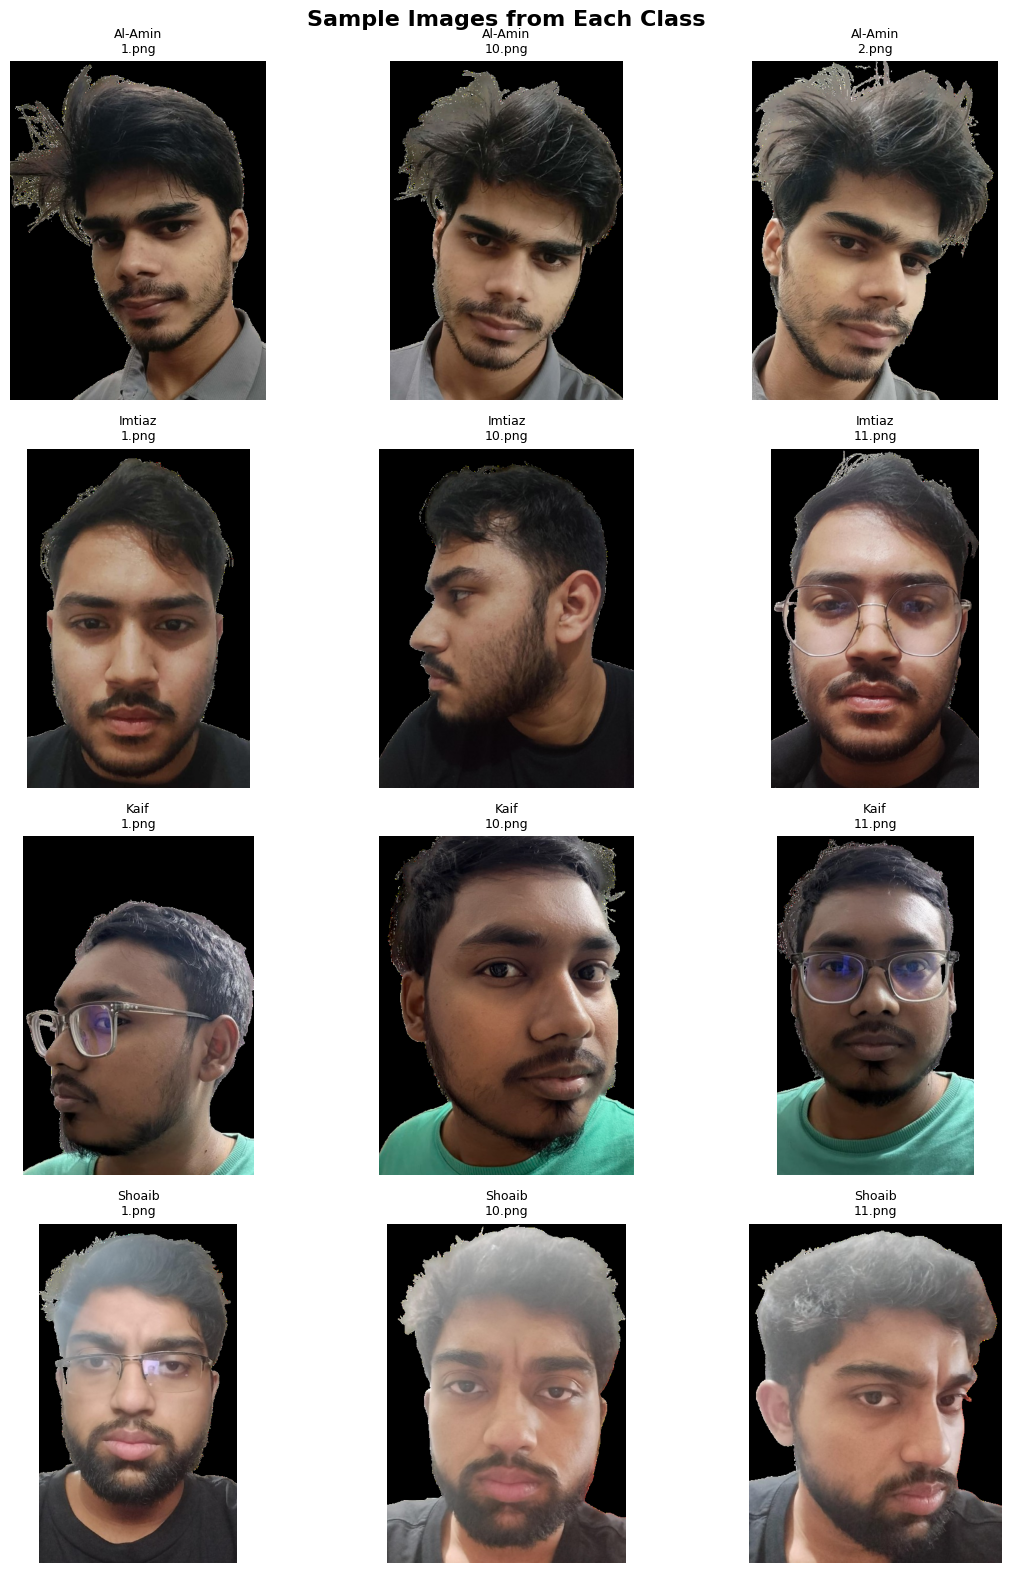

✅ Sample images displayed successfully!




In [16]:
# Display sample images from each class
print("Displaying sample images from each class...\n")

fig, axes = plt.subplots(len(CLASSES), 3, figsize=(12, 4*len(CLASSES)))
if len(CLASSES) == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for row, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_DIR, class_name)
    images = [f for f in os.listdir(class_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    for col in range(3):
        if col < len(images):
            img_path = os.path.join(class_path, images[col])
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"{class_name}\n{images[col]}", fontsize=9)
                axes[row, col].axis('off')
            except:
                axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample images displayed successfully!")
print("\n" + "="*60 + "\n")

In [17]:
# Check augmentation status (split-first cache)
print("="*60)
print("STEP 4: CHECKING AUGMENTATION STATUS")
print("="*60)

# Set this to True to force regeneration of data (e.g. after changing split logic)
FORCE_REPROCESS = True

# Create Augmented folder if it doesn't exist
if not os.path.exists(AUGMENTED_DIR):
    os.makedirs(AUGMENTED_DIR)
    print(f"✅ Created '{AUGMENTED_DIR}' folder\n")
else:
    print(f"✅ '{AUGMENTED_DIR}' folder exists\n")

def _pkl_paths(split_name: str, class_name: str):
    X_pkl = os.path.join(AUGMENTED_DIR, f"X_{split_name}_{class_name}.pkl")
    y_pkl = os.path.join(AUGMENTED_DIR, f"y_{split_name}_{class_name}.pkl")
    return X_pkl, y_pkl

augmentation_status = {}

print("Checking cached split files for each class:\n")
for class_name in tqdm(CLASSES, desc="Checking cached pickles", unit="class"):
    X_train_pkl, y_train_pkl = _pkl_paths('train', class_name)
    X_val_pkl, y_val_pkl = _pkl_paths('val', class_name)
    X_test_pkl, y_test_pkl = _pkl_paths('test', class_name)

    ok = True
    msg_parts = []

    # Train split must exist and reach target
    if os.path.exists(X_train_pkl) and os.path.exists(y_train_pkl):
        try:
            with open(X_train_pkl, 'rb') as f:
                Xtr = pickle.load(f)
            # Just check if we have a reasonable amount (e.g. > 0) since exact count depends on split
            if len(Xtr) > 0:
                msg_parts.append(f"train OK ({len(Xtr)})")
            else:
                ok = False
                msg_parts.append(f"train MISSING")
        except:
            ok = False
            msg_parts.append("train ERROR")
    else:
        ok = False
        msg_parts.append("train MISSING")

    # Val/test just need to exist
    if os.path.exists(X_val_pkl) and os.path.exists(y_val_pkl):
        msg_parts.append("val OK")
    else:
        ok = False
        msg_parts.append("val MISSING")

    if os.path.exists(X_test_pkl) and os.path.exists(y_test_pkl):
        msg_parts.append("test OK")
    else:
        ok = False
        msg_parts.append("test MISSING")

    augmentation_status[class_name] = "COMPLETE" if ok else " | ".join(msg_parts)

print("\n" + "-"*60)
print(f"{'Class':<15} {'Status':<60}")
print("-"*60)
for class_name in CLASSES:
    status = augmentation_status.get(class_name, "UNKNOWN")
    print(f"{class_name:<15} {status:<60}")
print("="*60 + "\n")

# Summary
to_process = [c for c, s in augmentation_status.items() if s != "COMPLETE"]
print(f"📊 SUMMARY: {len(CLASSES) - len(to_process)}/{len(CLASSES)} classes complete")
print(f"⏳ Pending processing: {len(to_process)} class(es)")

print("\nNOTE: Cached pickles are reused as-is.")
print("If you change augmentation/resizing settings, manually delete the old cached files once:")
print("  ./Augmented/X_train_<class>.pkl, y_train_<class>.pkl")
print("  ./Augmented/X_val_<class>.pkl,   y_val_<class>.pkl")
print("  ./Augmented/X_test_<class>.pkl,  y_test_<class>.pkl")
print("and optionally delete ./Augmented/<class>_Aug (preview JPGs).")
print("="*60 + "\n")

# Decision flag
AUGMENTATION_COMPLETE = len(to_process) == 0

if FORCE_REPROCESS:
    print("⚠️ FORCE_REPROCESS is True. Will regenerate all splits and augmentations.")
    AUGMENTATION_COMPLETE = False

if AUGMENTATION_COMPLETE:
    print("✨ ALL SPLITS ALREADY CACHED - WILL SKIP DATA PROCESSING STEP!")
else:
    print("🔄 SOME CLASSES NEED PROCESSING (OR FORCED) - WILL PROCESS IN NEXT STEP")
print("="*60 + "\n")

STEP 4: CHECKING AUGMENTATION STATUS
✅ './Augmented' folder exists

Checking cached split files for each class:



Checking cached pickles: 100%|██████████| 4/4 [00:00<00:00, 13304.69class/s]


------------------------------------------------------------
Class           Status                                                      
------------------------------------------------------------
Al-Amin         train MISSING | val MISSING | test MISSING                  
Imtiaz          train MISSING | val MISSING | test MISSING                  
Kaif            train MISSING | val MISSING | test MISSING                  
Shoaib          train MISSING | val MISSING | test MISSING                  

📊 SUMMARY: 0/4 classes complete
⏳ Pending processing: 4 class(es)

NOTE: Cached pickles are reused as-is.
If you change augmentation/resizing settings, manually delete the old cached files once:
  ./Augmented/X_train_<class>.pkl, y_train_<class>.pkl
  ./Augmented/X_val_<class>.pkl,   y_val_<class>.pkl
  ./Augmented/X_test_<class>.pkl,  y_test_<class>.pkl
and optionally delete ./Augmented/<class>_Aug (preview JPGs).

⚠️ FORCE_REPROCESS is True. Will regenerate all splits and augmentation

## Step 2: Data Augmentation & Preprocessing
Load original images, augment them to reach target count, resize to AlexNet input size, and save as pickle files

In [18]:
# Simple preprocessing with transparent background handling
def load_and_resize_images(class_name):
    """Load all images from a class folder and resize to IMG_SIZE.

    Handles images with transparent backgrounds by replacing transparency with white.
    This intentionally does NOT do any face detection/cropping.
    Use this when your dataset images are already face-focused (manually cropped)
    or you want to keep preprocessing minimal for the assignment.
    """
    from PIL import Image
    
    class_path = os.path.join(DATASET_DIR, class_name)
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
    ]

    X = []
    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            # Use PIL to handle transparent backgrounds properly
            pil_img = Image.open(img_path)
            
            # If image has transparency (RGBA), replace with white background
            if pil_img.mode == 'RGBA':
                # Create white background
                white_bg = Image.new('RGB', pil_img.size, (255, 255, 255))
                # Paste image with alpha channel as mask
                white_bg.paste(pil_img, mask=pil_img.split()[3])
                pil_img = white_bg
            elif pil_img.mode != 'RGB':
                # Convert other modes to RGB (e.g., grayscale to RGB)
                pil_img = pil_img.convert('RGB')
            
            # Resize using PIL
            pil_img = pil_img.resize(IMG_SIZE, Image.LANCZOS)
            
            # Convert to numpy array and normalize
            img_rgb = np.array(pil_img, dtype=np.float32) / 255.0
            X.append(img_rgb)
        except Exception as e:
            print(f"  ⚠️ Error loading {img_file}: {str(e)}")

    return np.array(X, dtype=np.float32)


print("✅ Preprocessing functions defined (transparent background handling enabled)")


✅ Preprocessing functions defined (transparent background handling enabled)


In [19]:
# Process each class: SPLIT ORIGINALS FIRST, then AUGMENT EACH SPLIT
print("\n" + "="*60)
print("STEP 5: DATA PROCESSING (SPLIT ORIGINALS -> AUGMENT EACH)")
print("="*60)

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6, "Split ratios must sum to 1.0"
rng = np.random.default_rng(42)

def _list_image_files(class_name: str):
    class_path = os.path.join(DATASET_DIR, class_name)
    files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
    ]
    return [os.path.join(class_path, f) for f in files]

def _pkl_paths(split_name: str, class_name: str):
    X_pkl = os.path.join(AUGMENTED_DIR, f"X_{split_name}_{class_name}.pkl")
    y_pkl = os.path.join(AUGMENTED_DIR, f"y_{split_name}_{class_name}.pkl")
    return X_pkl, y_pkl

def _split_dirs(class_name: str):
    base = os.path.join(SPLIT_IMAGES_DIR, class_name)
    return {
        'train': os.path.join(base, 'train'),
        'val': os.path.join(base, 'val'),
        'test': os.path.join(base, 'test'),
    }

def _load_paths_to_array(paths):
    X = []
    for p in paths:
        img_bgr = cv2.imread(p)
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)
        # Keep as float32 [0, 255] for processing
        img_rgb = img_rgb.astype(np.float32)
        X.append(img_rgb)
    return np.array(X, dtype=np.float32)

def _load_dir_images_to_array(dir_path: str, limit: int | None = None):
    if not os.path.exists(dir_path):
        return np.empty((0, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    files = sorted(files)
    if limit is not None:
        files = files[:limit]
    paths = [os.path.join(dir_path, f) for f in files]
    return _load_paths_to_array(paths)

def _count_dir_images(dir_path: str) -> int:
    if not os.path.exists(dir_path):
        return 0
    return sum(1 for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')))

def _save_split_pickles(class_name: str, split_name: str, X: np.ndarray, y: np.ndarray):
    X_pkl, y_pkl = _pkl_paths(split_name, class_name)
    with open(X_pkl, 'wb') as f:
        pickle.dump(X, f)
    with open(y_pkl, 'wb') as f:
        pickle.dump(y, f)

def _save_rgb_float_as_jpg(img_float: np.ndarray, out_path: str):
    # Ensure we are saving valid image data
    # 1. Clip to [0, 255] range
    img_clipped = np.clip(img_float, 0.0, 255.0)
    # 2. Convert to uint8
    img_u8 = img_clipped.astype(np.uint8)
    # 3. Convert RGB (internal) to BGR (OpenCV)
    img_bgr = cv2.cvtColor(img_u8, cv2.COLOR_RGB2BGR)
    # 4. Save
    success = cv2.imwrite(out_path, img_bgr)
    if not success:
        print(f"  ⚠️ Failed to save image: {out_path}")

def _augment_images(original_paths, target_count, datagen):
    """Load originals and augment them until target_count is reached."""
    if not original_paths:
        return np.empty((0, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    
    # 1. Load originals
    X_originals = _load_paths_to_array(original_paths)
    X_aug = list(X_originals)
    
    # 2. Augment
    needed = target_count - len(X_aug)
    if needed > 0:
        aug_count = 0
        # Loop repeatedly until we have enough
        while aug_count < needed:
            for img in X_originals:
                img_batch = img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 3)
                for batch in datagen.flow(img_batch, batch_size=1, shuffle=False):
                    aug_img = batch[0].astype(np.float32)
                    X_aug.append(aug_img)
                    aug_count += 1
                    break
                if aug_count >= needed:
                    break
    
    # 3. Limit and Shuffle
    X_aug = np.array(X_aug[:target_count], dtype=np.float32)
    indices = np.arange(len(X_aug))
    rng.shuffle(indices)
    return X_aug[indices]

all_train = {}
all_val = {}
all_test = {}
all_y_train = {}
all_y_val = {}
all_y_test = {}

if AUGMENTATION_COMPLETE:
    print("\n⚡ LOADING FROM EXISTING SPLIT PICKLES (FAST MODE)\n")
    for class_name in tqdm(CLASSES, desc="Loading cached splits", unit="class"):
        Xtr_p, ytr_p = _pkl_paths('train', class_name)
        Xva_p, yva_p = _pkl_paths('val', class_name)
        Xte_p, yte_p = _pkl_paths('test', class_name)

        with open(Xtr_p, 'rb') as f:
            Xtr = pickle.load(f)
        with open(ytr_p, 'rb') as f:
            ytr = pickle.load(f)
        with open(Xva_p, 'rb') as f:
            Xva = pickle.load(f)
        with open(yva_p, 'rb') as f:
            yva = pickle.load(f)
        with open(Xte_p, 'rb') as f:
            Xte = pickle.load(f)
        with open(yte_p, 'rb') as f:
            yte = pickle.load(f)

        all_train[class_name] = Xtr
        all_val[class_name] = Xva
        all_test[class_name] = Xte
        all_y_train[class_name] = ytr
        all_y_val[class_name] = yva
        all_y_test[class_name] = yte

        print(f"  ✅ {class_name}: train={len(Xtr)}, val={len(Xva)}, test={len(Xte)}")

else:
    print("\n🔄 SPLITTING ORIGINALS -> AUGMENTING EACH SPLIT\n")

    # Augmentation config
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        zoom_range=[0.95, 1.10],
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
    )

    if SAVE_SPLIT_IMAGES_TO_DISK:
        os.makedirs(SPLIT_IMAGES_DIR, exist_ok=True)

    for class_name in tqdm(CLASSES, desc="Processing classes", unit="class"):
        class_label = CLASS_LABELS[class_name]
        
        # 1. List and Shuffle Original Files
        paths = _list_image_files(class_name)
        if len(paths) == 0:
            print(f"  ❌ No images found for {class_name}")
            continue
        
        # Shuffle originals to ensure random split
        rng.shuffle(paths)
        
        # 2. Split Files
        n_total_files = len(paths)
        n_train_files = max(1, int(round(n_total_files * TRAIN_RATIO)))
        n_val_files = max(1, int(round(n_total_files * VAL_RATIO)))
        n_test_files = max(1, n_total_files - n_train_files - n_val_files)
        
        # Adjust to ensure we don't exceed total or leave empty if possible
        if n_train_files + n_val_files + n_test_files > n_total_files:
             n_val_files = max(1, n_val_files - 1)
        
        train_paths = paths[:n_train_files]
        val_paths = paths[n_train_files:n_train_files+n_val_files]
        test_paths = paths[n_train_files+n_val_files:]
        
        print(f"  {class_name}: Originals Split -> Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

        # 3. Calculate Target Counts for each split
        target_train = int(TOTAL_TARGET_IMAGES_PER_CLASS * TRAIN_RATIO)
        target_val = int(TOTAL_TARGET_IMAGES_PER_CLASS * VAL_RATIO)
        target_test = TOTAL_TARGET_IMAGES_PER_CLASS - target_train - target_val
        
        # 4. Augment Each Split Independently
        X_train = _augment_images(train_paths, target_train, datagen)
        X_val = _augment_images(val_paths, target_val, datagen)
        X_test = _augment_images(test_paths, target_test, datagen)
        
        # 5. Save to disk (if requested)
        if SAVE_SPLIT_IMAGES_TO_DISK:
            dirs = _split_dirs(class_name)
            for d in dirs.values():
                os.makedirs(d, exist_ok=True)
            
            # Save Train
            if _count_dir_images(dirs['train']) == 0:
                for i, img in enumerate(X_train):
                    _save_rgb_float_as_jpg(img, os.path.join(dirs['train'], f"train_{i:05d}.jpg"))
            
            # Save Val
            if _count_dir_images(dirs['val']) == 0:
                for i, img in enumerate(X_val):
                    _save_rgb_float_as_jpg(img, os.path.join(dirs['val'], f"val_{i:05d}.jpg"))
            
            # Save Test
            if _count_dir_images(dirs['test']) == 0:
                for i, img in enumerate(X_test):
                    _save_rgb_float_as_jpg(img, os.path.join(dirs['test'], f"test_{i:05d}.jpg"))

            # 6. Reload from disk (if requested)
            if BUILD_PKLS_FROM_SAVED_IMAGES:
                X_train = _load_dir_images_to_array(dirs['train'])
                X_val = _load_dir_images_to_array(dirs['val'])
                X_test = _load_dir_images_to_array(dirs['test'])

        # 7. Save PKLs
        y_train = np.full((len(X_train),), class_label, dtype=np.int64)
        y_val = np.full((len(X_val),), class_label, dtype=np.int64)
        y_test = np.full((len(X_test),), class_label, dtype=np.int64)

        _save_split_pickles(class_name, 'train', X_train, y_train)
        _save_split_pickles(class_name, 'val', X_val, y_val)
        _save_split_pickles(class_name, 'test', X_test, y_test)

        all_train[class_name] = X_train
        all_val[class_name] = X_val
        all_test[class_name] = X_test
        all_y_train[class_name] = y_train
        all_y_val[class_name] = y_val
        all_y_test[class_name] = y_test


STEP 5: DATA PROCESSING (SPLIT ORIGINALS -> AUGMENT EACH)

🔄 SPLITTING ORIGINALS -> AUGMENTING EACH SPLIT



Processing classes:   0%|          | 0/4 [00:00<?, ?class/s]

  Al-Amin: Originals Split -> Train: 7, Val: 2, Test: 1


Processing classes:  25%|██▌       | 1/4 [00:13<00:40, 13.52s/class]

  Imtiaz: Originals Split -> Train: 14, Val: 3, Test: 3


Processing classes:  50%|█████     | 2/4 [00:27<00:27, 13.52s/class]

  Kaif: Originals Split -> Train: 14, Val: 3, Test: 3


Processing classes:  75%|███████▌  | 3/4 [00:39<00:13, 13.21s/class]

  Shoaib: Originals Split -> Train: 17, Val: 4, Test: 3


Processing classes: 100%|██████████| 4/4 [00:53<00:00, 13.30s/class]


In [20]:
# Combine all classes into train/val/test datasets
print("\n" + "="*60)
print("STEP 6: COMBINING DATASETS (TRAIN/VAL/TEST)")
print("="*60)

X_train_combined = []
y_train_combined = []
X_val_combined = []
y_val_combined = []
X_test_combined = []
y_test_combined = []

for class_name in tqdm(CLASSES, desc="Combining data", unit="class"):
    if class_name in all_train:
        X_train_combined.append(all_train[class_name])
        y_train_combined.append(all_y_train[class_name])
    if class_name in all_val:
        X_val_combined.append(all_val[class_name])
        y_val_combined.append(all_y_val[class_name])
    if class_name in all_test:
        X_test_combined.append(all_test[class_name])
        y_test_combined.append(all_y_test[class_name])

X_train_combined = np.concatenate(X_train_combined, axis=0)
y_train_combined = np.concatenate(y_train_combined, axis=0)
X_val_combined = np.concatenate(X_val_combined, axis=0)
y_val_combined = np.concatenate(y_val_combined, axis=0)
X_test_combined = np.concatenate(X_test_combined, axis=0)
y_test_combined = np.concatenate(y_test_combined, axis=0)

# Shuffle TRAIN only
shuffle_idx = np.random.permutation(len(X_train_combined))
X_train_combined = X_train_combined[shuffle_idx]
y_train_combined = y_train_combined[shuffle_idx]

print(f"Train: X {X_train_combined.shape}, y {y_train_combined.shape}")
print(f"Val:   X {X_val_combined.shape}, y {y_val_combined.shape}")
print(f"Test:  X {X_test_combined.shape}, y {y_test_combined.shape}")
print(f"Train value range: [{X_train_combined.min():.3f}, {X_train_combined.max():.3f}]")
print("="*60 + "\n")


STEP 6: COMBINING DATASETS (TRAIN/VAL/TEST)


Combining data: 100%|██████████| 4/4 [00:00<00:00, 69327.34class/s]


Train: X (1400, 227, 227, 3), y (1400,)
Val:   X (300, 227, 227, 3), y (300,)
Test:  X (300, 227, 227, 3), y (300,)
Train value range: [0.000, 255.000]



## Step 3: Model Building
Build AlexNet architecture adapted for face recognition with dynamic number of classes

In [21]:
# Build AlexNet model (Modified from M_3A1_alexnet.ipynb for multiple classes)
print("="*60)
print("STEP 7: BUILDING ALEXNET MODEL")
print("="*60)

# Get number of classes dynamically
NUM_CLASSES = len(CLASSES)

print(f"\nModel Configuration:")
print(f"  Input size: {IMG_SIZE[0]} x {IMG_SIZE[1]} x 3")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Classes: {', '.join(CLASSES)}\n")

# Note: Too-strong L2 (e.g., 0.001) can dominate the loss on small datasets.
L2_COEFF = 0.001

# Build AlexNet model (following original M_3A1 structure)
model = keras.Sequential([
    ## input layer
    keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(units=4096, kernel_regularizer=keras.regularizers.l2(L2_COEFF)),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(units=4096, kernel_regularizer=keras.regularizers.l2(L2_COEFF)),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(NUM_CLASSES),  # Modified: Dynamic output classes
    layers.Activation('softmax')
])

print("✅ AlexNet model built successfully!")
print(f"  L2 coeff: {L2_COEFF}")
print("="*60)

STEP 7: BUILDING ALEXNET MODEL

Model Configuration:
  Input size: 227 x 227 x 3
  Number of classes: 4
  Classes: Al-Amin, Imtiaz, Kaif, Shoaib

✅ AlexNet model built successfully!
  L2 coeff: 0.001


In [22]:
# Display model architecture
print("\n" + "="*60)
print("MODEL ARCHITECTURE SUMMARY")
print("="*60 + "\n")

model.summary()

print("\n" + "="*60)


MODEL ARCHITECTURE SUMMARY



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,336,004 (222.53 MB)

 Trainable params: 58,316,868 (222.46 MB)

 Non-trainable params: 19,136 (74.75 KB)

In [23]:
# Compile the model (Modified from M_3B1_alexnet for better training)
print("\n" + "="*60)
print("STEP 8: COMPILING MODEL")
print("="*60)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model compiled successfully!")
print("  Optimizer: Adam (learning_rate=1e-4, clipnorm=1.0)")
print("  Loss: sparse_categorical_crossentropy")
print("  Metrics: accuracy")
print("="*60 + "\n")


STEP 8: COMPILING MODEL

✅ Model compiled successfully!
  Optimizer: Adam (learning_rate=1e-4, clipnorm=1.0)
  Loss: sparse_categorical_crossentropy
  Metrics: accuracy



In [24]:
# Prepare training / validation / testing data (already split earlier)
print("="*60)
print("STEP 9: NORMALIZATION (MEAN SUBTRACTION) + DISTRIBUTION CHECK")
print("="*60)

# Calculate mean image from training data (following AlexNet notebooks)
print("\nCalculating mean image from TRAIN for normalization...")
mean_img = np.mean(X_train_combined, axis=0)

# Normalize using mean subtraction
X_train_norm = X_train_combined - mean_img
X_val_norm = X_val_combined - mean_img
X_test_norm = X_test_combined - mean_img

print(f"Train: {X_train_norm.shape}, range [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")
print(f"Val:   {X_val_norm.shape}")
print(f"Test:  {X_test_norm.shape}")

# Verify class distribution
print("\nClass distribution in training set:")
for class_name in CLASSES:
    class_idx = CLASS_LABELS[class_name]
    count = np.sum(y_train_combined == class_idx)
    print(f"  {class_name:<15}: {count} images")

print("\nClass distribution in validation set:")
for class_name in CLASSES:
    class_idx = CLASS_LABELS[class_name]
    count = np.sum(y_val_combined == class_idx)
    print(f"  {class_name:<15}: {count} images")

print("\nClass distribution in test set:")
for class_name in CLASSES:
    class_idx = CLASS_LABELS[class_name]
    count = np.sum(y_test_combined == class_idx)
    print(f"  {class_name:<15}: {count} images")

print("="*60 + "\n")

# For training code below (keeps variable names unchanged)
y_train = y_train_combined
y_val = y_val_combined
y_test = y_test_combined

STEP 9: NORMALIZATION (MEAN SUBTRACTION) + DISTRIBUTION CHECK

Calculating mean image from TRAIN for normalization...
Train: (1400, 227, 227, 3), range [-140.268, 247.691]
Val:   (300, 227, 227, 3)
Test:  (300, 227, 227, 3)

Class distribution in training set:
  Al-Amin        : 350 images
  Imtiaz         : 350 images
  Kaif           : 350 images
  Shoaib         : 350 images

Class distribution in validation set:
  Al-Amin        : 75 images
  Imtiaz         : 75 images
  Kaif           : 75 images
  Shoaib         : 75 images

Class distribution in test set:
  Al-Amin        : 75 images
  Imtiaz         : 75 images
  Kaif           : 75 images
  Shoaib         : 75 images



## Step 4: Model Training
Train the AlexNet model on augmented training data with normalized inputs

In [25]:
# Train the model (following AlexNet notebook style)
print("="*60)
print("STEP 10: TRAINING MODEL")
print("="*60)

# Set training parameters
EPOCHS = 30
BATCH_SIZE = 32

print("\nTraining Configuration:")
print(f"  Epochs: {EPOCHS} (with EarlyStopping)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples:   {X_train_norm.shape[0]}")
print(f"  Validation samples: {X_val_norm.shape[0]}\n")

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1,
)

print("Starting training...\n")
history = model.fit(
    x=X_train_norm,
    y=y_train,
    epochs=EPOCHS,
    validation_data=(X_val_norm, y_val),
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1,
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60 + "\n")

STEP 10: TRAINING MODEL

Training Configuration:
  Epochs: 30 (with EarlyStopping)
  Batch size: 32
  Training samples:   1400
  Validation samples: 300

Starting training...

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 518ms/step - accuracy: 0.8814 - loss: 10.0186 - val_accuracy: 0.2600 - val_loss: 12.6922
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 508ms/step - accuracy: 0.9750 - loss: 9.4169 - val_accuracy: 0.6233 - val_loss: 10.8309
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 492ms/step - accuracy: 0.9879 - loss: 8.7381 - val_accuracy: 0.8300 - val_loss: 9.0802
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 504ms/step - accuracy: 0.9979 - loss: 7.7980 - val_accuracy: 0.8800 - val_loss: 7.9425
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.9871 - loss: 6.9554 - val_accuracy: 0.8033 - val_loss: 8.2505
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step - accuracy: 0.9950 - loss: 6.2364 - val_accuracy: 0.9133 - val_loss: 6.3615
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 509ms

STEP 11: PLOTTING TRAINING HISTORY



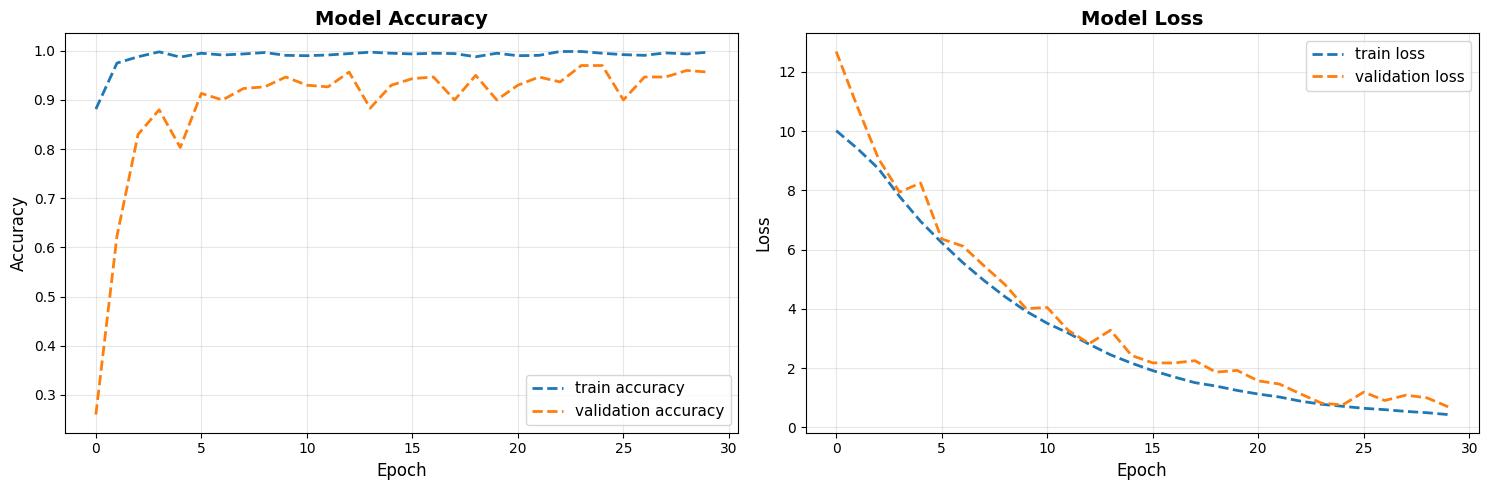

✅ Training history plotted successfully!



In [26]:
# Plot training history (following M_3B1_alexnet approach)
print("="*60)
print("STEP 11: PLOTTING TRAINING HISTORY")
print("="*60 + "\n")

plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], '--', label='train accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], '--', label='validation accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=11)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='train loss', linewidth=2)
plt.plot(history.history['val_loss'], '--', label='validation loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Training history plotted successfully!")
print("="*60 + "\n")

STEP 12: MODEL EVALUATION ON TEST SET

Test Results:
  Test Loss: 0.5346
  Test Accuracy: 0.9733 (97.33%)

Generating predictions for detailed metrics...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

     Al-Amin       1.00      1.00      1.00        75
      Imtiaz       0.90      1.00      0.95        75
        Kaif       1.00      1.00      1.00        75
      Shoaib       1.00      0.89      0.94        75

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.97      0.97       300

------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------


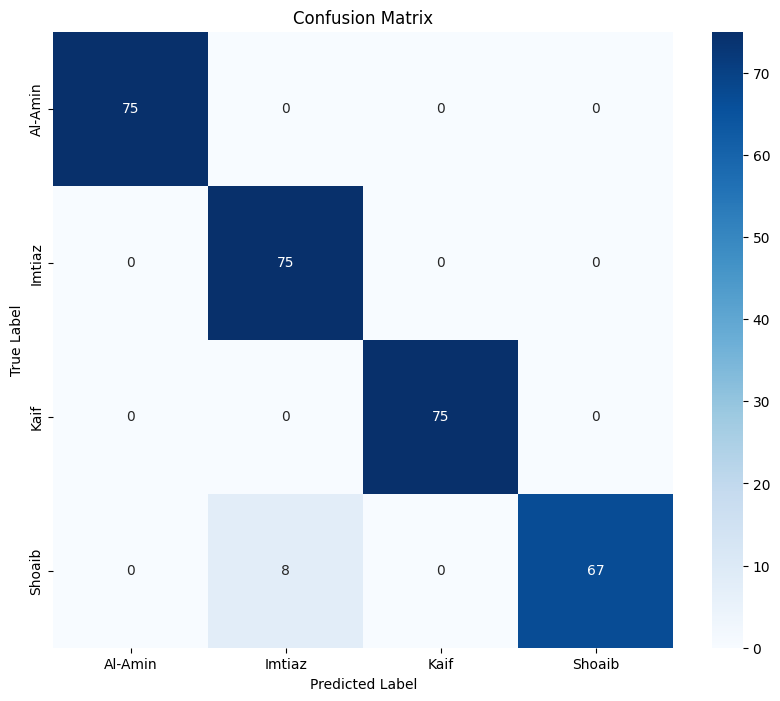

In [27]:
# Evaluate model on held-out test set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("="*60)
print("STEP 12: MODEL EVALUATION ON TEST SET")
print("="*60 + "\n")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test, verbose=0)

print("Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
print("\nGenerating predictions for detailed metrics...")
y_pred_prob = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report (Precision, Recall, F1-Score)
print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=CLASSES))

# Confusion Matrix
print("-" * 60)
print("CONFUSION MATRIX")
print("-" * 60)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("="*60 + "\n")

In [28]:
# Save the trained model
print("="*60)
print("STEP 13: SAVING TRAINED MODEL & ARTIFACTS")
print("="*60 + "\n")

# Create models folder if it doesn't exist
MODELS_DIR = "./Models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"✅ Created '{MODELS_DIR}' folder\n")

# 1. Save Model
model_path = os.path.join(MODELS_DIR, "alexnet_face_recognition.h5")
model.save(model_path)

print(f"✅ Model saved successfully!")
print(f"  Path: {model_path}")
print(f"  File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# 2. Save Class Labels
labels_path = os.path.join(MODELS_DIR, "class_labels.pkl")
with open(labels_path, 'wb') as f:
    pickle.dump(CLASS_LABELS, f)

print(f"\n✅ Class labels mapping saved!")
print(f"  Path: {labels_path}")
print(f"  Classes: {list(CLASS_LABELS.keys())}")

# 3. Save Mean Image (CRITICAL for correct inference)
# We need to subtract this same mean from webcam images
mean_img_path = os.path.join(MODELS_DIR, "mean_image.pkl")
with open(mean_img_path, 'wb') as f:
    pickle.dump(mean_img, f)

print(f"\n✅ Mean image saved!")
print(f"  Path: {mean_img_path}")
print(f"  Shape: {mean_img.shape}")

print("\n" + "="*60 + "\n")

STEP 13: SAVING TRAINED MODEL & ARTIFACTS

✅ Created './Models' folder

✅ Model saved successfully!
  Path: ./Models\alexnet_face_recognition.h5
  File size: 667.59 MB

✅ Class labels mapping saved!
  Path: ./Models\class_labels.pkl
  Classes: ['Al-Amin', 'Imtiaz', 'Kaif', 'Shoaib']

✅ Mean image saved!
  Path: ./Models\mean_image.pkl
  Shape: (227, 227, 3)


